# Naive Conformal Predictions - William Kiger

In [1]:
import os
import sys
import random
import time
import re
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 

#PyTorch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader

In [2]:
#setting seeds to 0 for reproducability
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])


cudnn.benchmark = True
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = " + str(device))

model_path = r"model/resnet_18_derm_model_test_v2.pt"
model = torch.load(model_path)
# model.to(device)
model = torch.nn.DataParallel(model)  # wdk...for multi-gpu instances
#model to eval mode
_ = model.eval()

Device = cuda:0


In [3]:
num_images = 890
num_calib = 10

class_names_dict = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}

class_names = list(class_names_dict.values())

In [4]:
def inference(model, test_image_name, print_bool):

    prediction_set = []
    
    transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

    test_image = Image.open(test_image_name)
    
    if print_bool: 
        plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(10, dim=1)
#         print(topk, topclass)
        cls = class_names[topclass[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(10): #10 is the hardcoded num of classes
            topclass.cpu().numpy()[0][i]
            
            if print_bool: 
                print("Prediction", i+1, ":", class_names_dict[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i]*100)
            class_num = class_names[topclass.cpu().numpy()[0][i]]
            score = topk.cpu().numpy()[0][i]*100
            prediction_set.append((class_num, score))
            
    return prediction_set

# Given: 
    calibration dataset 
    a model
    new image

In [5]:
#calibration dataset prepared
root = r'data\validation_dataset'
validate_path = os.path.join(root, 'val')

calibration_dataset, validation_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder(validate_path, transform), [100, 890-100]) #[num, num_image-num]

calib_loader = torch.utils.data.DataLoader(
    calibration_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [6]:
#our model
model_path = r"model/resnet_18_derm_model_test_v2.pt"
model = torch.load(model_path)
# model.to(device)
model = torch.nn.DataParallel(model)  # wdk...for multi-gpu instances
#model to eval mode
_ = model.eval()

(234, 254)


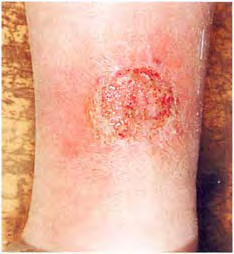

In [7]:
#image 
acd_img_path = r'data\validation_dataset\val\allergic_contact_dermatitis\404.jpg'
acd_img = Image.open(acd_img_path) 
print(acd_img.size)
display(acd_img)

# Working with a "coverage" guarantee

English : The probablility that the new label is in the prediction set is great than or equal to the one minus alpha "aka" the error rate


Prediction 1 : allergic_contact_dermatitis , Score:  29.513606429100037
Prediction 2 : squamous_cell_carcinoma , Score:  20.571844279766083
Prediction 3 : psoriasis , Score:  17.21981018781662
Prediction 4 : sarcoidosis , Score:  13.01594227552414
Prediction 5 : basal_cell_carcinoma , Score:  7.572384178638458
Prediction 6 : lupus_erythematosus , Score:  4.452983662486076
Prediction 7 : photodermatoses , Score:  3.6653485149145126
Prediction 8 : neutrophilic_dermatoses , Score:  2.095896936953068
Prediction 9 : lichen_planus , Score:  1.812148094177246
Prediction 10 : folliculitis , Score:  0.08003284456208348


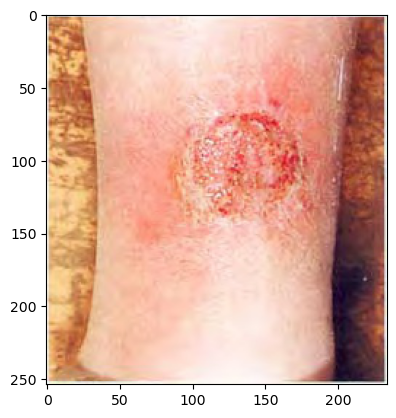

In [8]:
#looking at the softmax scores from our model
_ = inference(model, acd_img_path, print_bool=True)

# Now to get the Naive Coverage down...

# This is the logic of the algorithm
https://people.eecs.berkeley.edu/~angelopoulos/blog/posts/conformal-classification/

<img src='images\naive.png'>

In [9]:
predictions = inference(model, acd_img_path, print_bool=False)
predictions

[('allergic_contact_dermatitis', 29.513606429100037),
 ('squamous_cell_carcinoma', 20.571844279766083),
 ('psoriasis', 17.21981018781662),
 ('sarcoidosis', 13.01594227552414),
 ('basal_cell_carcinoma', 7.572384178638458),
 ('lupus_erythematosus', 4.452983662486076),
 ('photodermatoses', 3.6653485149145126),
 ('neutrophilic_dermatoses', 2.095896936953068),
 ('lichen_planus', 1.812148094177246),
 ('folliculitis', 0.08003284456208348)]

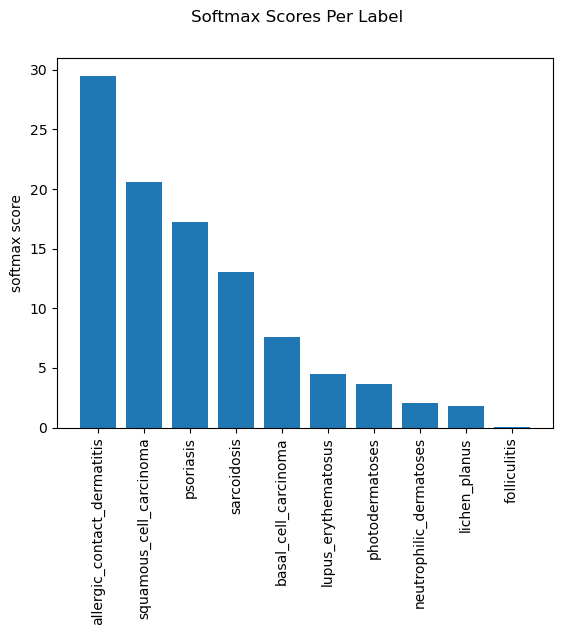

In [10]:
label = []
score = []

for item in predictions:
    label.append(item[0])
    score.append(item[1])   
    
y_pos = range(len(label))
plt.bar(y_pos, score)
plt.xticks(y_pos, label, rotation=90)# Rotation of the bars names
plt.suptitle("Softmax Scores Per Label")
plt.ylabel("softmax score")
plt.show()

In [11]:
# E sub i is the score of the correct class
correct_index = [i for i, v in enumerate(predictions) if v[0] == 'allergic_contact_dermatitis']
e_subi = predictions[correct_index[0]][1]


print(correct_index) #find the correct index
print(predictions[correct_index[0]][1]) #this will get the score for each prediction

[0]
29.513606429100037


In [12]:
#test for probablilty distrobution correctness of softmax scores - should sum to 100 (percent)
sum = 0 
for i in predictions: 
#     print(i)
    sum += i[1]
    
print(round(sum)) #account for float

100


# Naive Conformal Prediction

In [13]:
#this will hold our softmax buckets for each class
class Cp_Class(list):
    def __init__(self, name):
        self.name = name
        self.scores = []
        
    def get_q_hat(self): 
        np_arr = np.array(self.scores)
        #qhat taking the 10% quantile here
        q_hat = np.quantile(np_arr, 0.1, method="lower")
        return q_hat

In [14]:
# # got this logic from the below link
# # https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
def predict(model, test_image_tensor, print_bool):
    prediction_set = []
      
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(10, dim=1)
#         print(topk, topclass)
        cls = class_names[topclass[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(10): #10 is the hardcoded num of classes
            topclass.cpu().numpy()[0][i]
            
            if print_bool: 
                print("Prediction", i+1, ":", class_names_dict[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i]*100)
            
            class_num = class_names[topclass.cpu().numpy()[0][i]]
            score = topk.cpu().numpy()[0][i]*100
            prediction_set.append((class_num, score))
            
    return prediction_set

In [16]:
# calibration set has 890 images in the 10 available classes
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
        ])
data_dir = r'data\validation_dataset'
dataset = ImageFolderWithPaths(root=data_dir, transform=transform)
dataset = DataLoader(dataset=dataset)

class_names = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}
class_names = list(class_names.values())
# print(class_names)

classObj_list = []

model.eval() #eval mode

count = 0

with torch.no_grad():
    for batch in dataset:       
        
        path = batch[2]
        path = path[0] #pull path from tuple
        label_correct = path.split('\\')[3] #this is getting the label from the path 
#         print(label_correct)         
        
        if torch.cuda.is_available():
            test_image_tensor = batch[0].view(1, 3, 224, 224).cuda()
        else:
            test_image_tensor = batch[0].view(1, 3, 224, 224)
        
        #getting the inference...softmax scores in the list
        sft_mx_scrs_list = predict(model, test_image_tensor, print_bool=False)
        
        #loop through softmax scores ensure found correct score
        name = ''
        ground_truth_score = ''
        for index, tuple in enumerate(sft_mx_scrs_list):            
            #if prediction is the correct label --> record score in object
            if sft_mx_scrs_list[index][0] == label_correct:
                name = label_correct
                #now get score
                ground_truth_score = sft_mx_scrs_list[index][1]
                
        #we now have the truth class score and softmax score        
        #if obj in list doesnt exist, make entry in the conformal prediction class list 
        idx = 0
        found_bool = False
        
        if not classObj_list == []: 
            for i in classObj_list:#if the class exists, append the softmax score to the scores list member
                if classObj_list[idx].name == name: 
                    found_bool = True
                    classObj_list[idx].scores.append(ground_truth_score/100)
                idx+=1
                
        #if there is not already a class object matching the ground truth, make one and add the scores         
        if found_bool == False:       
            e_sub_i = Cp_Class(name)
            e_sub_i.scores.append(ground_truth_score/100)
            classObj_list.append(e_sub_i)
        
        count += 1
        
print(count)    

890


In [17]:
#testing
myobj = classObj_list[9].name
print(myobj)
print(classObj_list[9].scores)
print(classObj_list[9].get_q_hat())
print(len(classObj_list))

squamous_cell_carcinoma
[0.06762370467185974, 0.9802404642105103, 0.6037493348121643, 0.47880473732948303, 0.3596634566783905, 0.4380248785018921, 0.9785478711128235, 0.6686840057373047, 0.9202235341072083, 0.9933053851127625, 0.3690345585346222, 0.2831602990627289, 0.1825990527868271, 0.512144148349762, 0.4367824196815491, 0.4344145953655243, 0.16315962374210358, 0.8606183528900146, 0.06293826550245285, 0.02934931591153145, 0.3464931547641754, 0.9762646555900574, 0.6381998658180237, 0.9688699841499329, 0.2157498598098755, 0.06026121973991394, 0.1893203854560852, 0.5461398363113403, 0.05517769232392311, 0.06821543723344803, 0.12370266020298004, 0.23777227103710175, 0.7509344220161438, 0.3576381802558899, 0.16135409474372864, 0.8959810733795166, 0.10954660177230835, 0.5470215678215027, 0.08972664177417755, 0.016344202682375908, 0.01892152428627014, 0.06638972461223602, 0.9231147170066833, 0.03890807554125786, 0.08951324224472046, 0.23627889156341553, 0.14315049350261688, 0.8716282248497

In [18]:
print(classObj_list[0].name)
print(classObj_list[0].get_q_hat())
print(classObj_list[0].scores)

allergic_contact_dermatitis
0.05583157390356064
[0.7205329537391663, 0.06608912348747253, 0.18511781096458435, 0.059246014803647995, 0.2906953692436218, 0.11198808997869492, 0.4471568465232849, 0.27089723944664, 0.37290236353874207, 0.5506329536437988, 0.11418596655130386, 0.14247140288352966, 0.3372928202152252, 0.14870718121528625, 0.10295303910970688, 0.25423452258110046, 0.27131906151771545, 0.2115325629711151, 0.012666181661188602, 0.1177741065621376, 0.056275006383657455, 0.18704287707805634, 0.041801899671554565, 0.3541373014450073, 0.29088202118873596, 0.3917974531650543, 0.8771113753318787, 0.18952970206737518, 0.46227139234542847, 0.10697752237319946, 0.4692854881286621, 0.29259586334228516, 0.2570001482963562, 0.25234454870224, 0.4193374812602997, 0.4470933675765991, 0.3290465474128723, 0.2991222143173218, 0.16409839689731598, 0.8077905178070068, 0.32284435629844666, 0.15890023112297058, 0.03706144914031029, 0.38737088441848755, 0.42971140146255493, 0.08992709964513779, 0.31

In [19]:
calibration_threashold = []
idx = 0
for i in classObj_list: 
#     print(classObj_list[idx].name)
#     print(classObj_list[idx].get_q_hat())
    calibration_threashold.append((classObj_list[idx].name,classObj_list[idx].get_q_hat()))
    idx += 1

In [20]:
calibration_threashold

[('allergic_contact_dermatitis', 0.05583157390356064),
 ('basal_cell_carcinoma', 0.015223694033920765),
 ('folliculitis', 0.02149542234838009),
 ('lichen_planus', 0.028841115534305573),
 ('lupus_erythematosus', 0.031862933188676834),
 ('neutrophilic_dermatoses', 0.013008948415517807),
 ('photodermatoses', 0.011723936535418034),
 ('psoriasis', 0.07786711305379868),
 ('sarcoidosis', 0.021452058106660843),
 ('squamous_cell_carcinoma', 0.034630898386240005)]

In [21]:
def NaiveConformalPrediction(model, test_image_name, print_bool):
    prediction_set = []
    
    transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

    test_image = Image.open(test_image_name)
    
    if print_bool: 
        plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(10, dim=1)

        cls = class_names[topclass[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(10): #10 is the hardcoded num of classes
            topclass.cpu().numpy()[0][i]
            
            if print_bool: 
                print("Prediction", i+1, ":", class_names_dict[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i]*100)
            class_num = class_names[topclass.cpu().numpy()[0][i]]
            score = topk.cpu().numpy()[0][i]*100
            prediction_set.append((class_num, score))
            
    ncp_list = []
    
    #steps -- look up threshold 
    top_class = class_names[topclass[0][0]]
    threshold = [ (x,y) for x, y in calibration_threashold if x  == top_class ]
    threshold = threshold[0][1]

    #append to new list everything greater than threshold 
    idx = 0 
    for i in prediction_set: 
        #first, divide by 100 to get true percentage
        label = prediction_set[idx][0]
        value = prediction_set[idx][1]/100
        
        if value >= threshold: 
            ncp_list.append((label,value))
        idx += 1
                 
    return ncp_list

# Test Naive Conformal Prediction

# Linchen planus

In [22]:
#Naive Conformal Prediction
path = r"data\validation_dataset\val\lichen_planus\60.jpg"
cp = NaiveConformalPrediction(model, path, print_bool=False)
print(cp)

[('lichen_planus', 0.9959959983825684)]


In [23]:
#Just the softmax
path = r"data\validation_dataset\val\lichen_planus\60.jpg"
sft_mx_scores = inference(model, path, print_bool=False)
print(sft_mx_scores)

[('lichen_planus', 99.59959983825684), ('folliculitis', 0.18046897603198886), ('photodermatoses', 0.10230616899207234), ('allergic_contact_dermatitis', 0.07412222330458462), ('sarcoidosis', 0.0353050883859396), ('psoriasis', 0.004412793350638822), ('basal_cell_carcinoma', 0.0032037689379649237), ('lupus_erythematosus', 0.00025463518795731943), ('neutrophilic_dermatoses', 0.00018707166873355163), ('squamous_cell_carcinoma', 0.00013037158623774303)]


# Psoriasis

In [24]:
#Naive Conformal Prediction
path = r"data\validation_dataset\val\psoriasis\156.jpg"
cp = NaiveConformalPrediction(model, path, print_bool=False)
print(cp)

[('lupus_erythematosus', 0.7038368582725525), ('psoriasis', 0.2919107973575592)]


In [25]:
#Just the softmax
path = r"data\validation_dataset\val\psoriasis\156.jpg"
sft_mx_scores = inference(model, path, print_bool=False)
print(sft_mx_scores)

[('lupus_erythematosus', 70.38368582725525), ('psoriasis', 29.19107973575592), ('lichen_planus', 0.28673713095486164), ('neutrophilic_dermatoses', 0.06740543758496642), ('squamous_cell_carcinoma', 0.03298865631222725), ('folliculitis', 0.029176476527936757), ('allergic_contact_dermatitis', 0.004228507532388903), ('basal_cell_carcinoma', 0.003000431570399087), ('sarcoidosis', 0.0015459472706425004), ('photodermatoses', 0.00014609672689402942)]
